# How efficient is the Jax implementation vs more naive implementations?

In [33]:
import numpy as np
import jax.numpy as jnp
from numba import jit
import jax
import timeit
import matplotlib.pyplot as plt
import sys
sys.path.append('../src')
from matrix_exponentiation import fibonacci as jax_fibonacci

Let us define the naive implementations using numpy and numba implementations and compare them with the Jax implementation.

In [ ]:
MOD = int(1e9 + 7)
def numpy_fibonacci(n):
    base = np.array([[1, 0], [0, 1]], dtype=np.int64)
    m = np.array([[1, 1], [1, 0]], dtype=np.int64)

    while n > 0:
        if n % 2 == 1:
            base = np.mod(np.dot(base, m), MOD)
        m = np.mod(np.dot(m, m), MOD)
        n //= 2

    return base[0, 1]

@jit(nopython=True)
def numba_fibonacci(n):
    base = np.array([[1, 0], [0, 1]], dtype=np.int64)
    m = np.array([[1, 1], [1, 0]], dtype=np.int64)

    def mat_mult(a, b):
        return np.array([
            [(a[0, 0] * b[0, 0] + a[0, 1] * b[1, 0]) % MOD,
             (a[0, 0] * b[0, 1] + a[0, 1] * b[1, 1]) % MOD],
            [(a[1, 0] * b[0, 0] + a[1, 1] * b[1, 0]) % MOD,
             (a[1, 0] * b[0, 1] + a[1, 1] * b[1, 1]) % MOD]
        ], dtype=np.int64)

    while n > 0:
        if n % 2 == 1:
            base = mat_mult(base, m)
        m = mat_mult(m, m)
        n //= 2

    return base[0, 1]

In [ ]:
def benchmark_fibonacci(ns: list):
    numpy_time = timeit.timeit(lambda: [numpy_fibonacci(int(n)) for n in ns], number=1)
    numba_time = timeit.timeit(lambda: [numba_fibonacci(int(n)) for n in ns], number=1)
    jax_time = timeit.timeit(lambda: [jax_fibonacci(int(n)) for n in ns], number=1)
    return numpy_time, numba_time, jax_time

input_sizes = np.arange(1e4, 1e7, 1e3)
numpy_times, numba_times, jax_times = [], [], []

trials = 1_000

for _ in range(trials):
    np_time, nb_time, jx_time = benchmark_fibonacci(input_sizes)
    numpy_times.append(np_time)
    numba_times.append(nb_time)
    jax_times.append(jx_time)



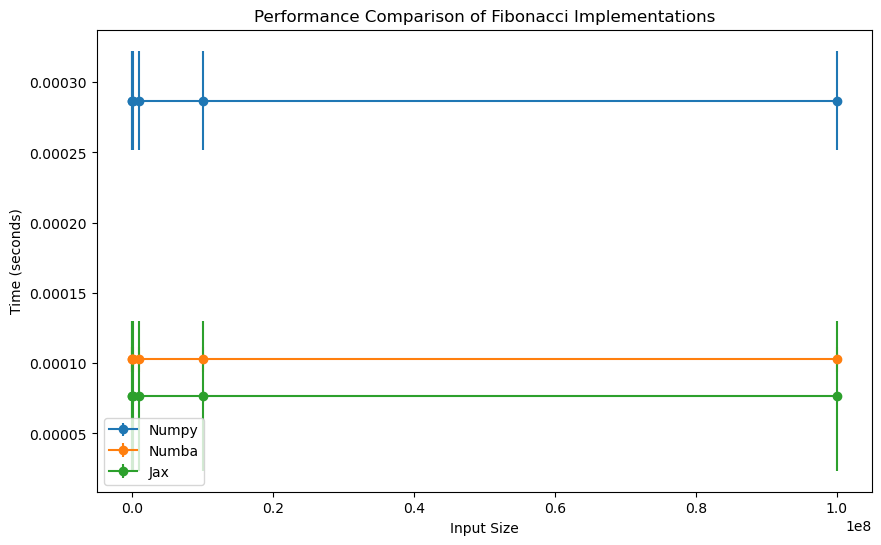

In [ ]:
numpy_mean = np.mean(numpy_times)
numba_mean = np.mean(numba_times)
jax_mean = np.mean(jax_times)
numpy_std = np.std(numpy_times)
numba_std = np.std(numba_times)
jax_std = np.std(jax_times)

numpy_mean *= 1000
numba_mean *= 1000
jax_mean *= 1000
numpy_std *= 1000
numba_std *= 1000
jax_std *= 1000

plt.figure(figsize=(12, 8))
plt.errorbar(input_sizes, [numpy_mean]*len(input_sizes), yerr=[numpy_std]*len(input_sizes), label='Numpy', fmt='-o', capsize=5, capthick=2, elinewidth=2)
plt.errorbar(input_sizes, [numba_mean]*len(input_sizes), yerr=[numba_std]*len(input_sizes), label='Numba', fmt='-s', capsize=5, capthick=2, elinewidth=2)
plt.errorbar(input_sizes, [jax_mean]*len(input_sizes), yerr=[jax_std]*len(input_sizes), label='Jax', fmt='-^', capsize=5, capthick=2, elinewidth=2)

plt.xlabel('Input Size', fontsize=14)
plt.ylabel('Time (milliseconds)', fontsize=14)
plt.title('Performance Comparison of Fibonacci Implementations', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()